<a href="https://colab.research.google.com/github/bhupeshmahara/INSAID-GCD-Capstone/blob/main/1005_GCD_Capstone_Project_Bhupesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h2>GCD Capstone Project : Employee Retention</h2></center>
<center><h3>Group ID : 1005</h3></center>

# 1. Problem Statement

Predict whether or not an employee would stay given the data of employees at a company.

Your client for this project is the HR Department at a software company.

    They want to try a new initiative to retain employees.
    The idea is to use data to predict whether an employee is likely to leave.
    Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.
    They only want to deal with the data that is related to permanent employees.

Current Practice
Once an employee leaves, he or she is taken an interview with the name "exit interview" and shares reasons for leaving. The HR Department then tries and learns insights from the interview and makes changes accordingly.

This suffers from the following problems:

    This approach is that it's too haphazard. The quality of insight gained from an interview depends heavily on the skill of the interviewer.
    The second problem is these insights can't be aggregated and interlaced across all employees who have left.
    The third is that it is too late by the time the proposed policy changes take effect.

The HR department has hired you as data science consultants. They want to supplement their exit interviews with a more proactive approach.


### Your Role

    You are given datasets of past employees and their status (still employed or already left).
    Your task is to build a classification model using the datasets.
    Because there was no machine learning model for this problem in the company, you don’t have quantifiable win condition. 
    You need to build the best possible model.


### Problem Specifics
    Deliverable: Predict whether an employee will stay or leave.
    Machine learning task: Classification
    Target variable: Status (Employed/Left)
    Win condition: N/A (best possible model)

# 2. Data Description



The Business Intelligence Analysts of the Company provided you three datasets that contain information about past employees and their status (still employed or already left).

    department_data

    This dataset contains information about each department. The schema of the dataset is as follows:
        dept_id – Unique Department Code
        dept_name – Name of the Department
        dept_head – Name of the Head of the Department

    employee_details_data

    This dataset consists of Employee ID, their Age, Gender and Marital Status. The schema of this dataset is as follows:
        employee_id – Unique ID Number for each employee
        age – Age of the employee
        gender – Gender of the employee
        marital_status – Marital Status of the employee

    employee_data

    This dataset consists of each employee’s Administrative Information, Workload Information, Mutual Evaluation Information and Status.

    Target variable
        status – Current employment status (Employed / Left)

    Administrative information
        department – Department to which the employees belong(ed) to
        salary – Salary level with respect to rest of their department
        tenure – Number of years at the company
        recently_promoted – Was the employee promoted in the last 3 years?
        employee_id – Unique ID Number for each employee

    Workload information
        n_projects – Number of projects employee has worked on
        avg_monthly_hrs – Average number of hours worked per month

    Mutual evaluation information
        satisfaction – Score for employee’s satisfaction with the company (higher is better)
        last_evaluation – Score for most recent evaluation of employee (higher is better)
        filed_complaint – Has the employee filed a formal complaint in the last 3 years?


# 3. Exploratory Data Analysis

In [1]:
!pip install mysql-connector-python

In [2]:
# Database 
import mysql.connector
from mysql.connector import Error
from collections import Counter

#### Data Source
Download the DataSets onto Python by connecting to the below provided MySQL instance.
                      
    host        'cpanel.insaid.co'
    user 	   'student'
    passwd      'student'
    database    'Capstone2'

In [3]:
# import basic libraries
import pandas as pd
import numpy as np

# import the required libraries from sklearn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [4]:
try:
    mySQLconnection = mysql.connector.connect(host='cpanel.insaid.co',
                             database='Capstone2',
                             user='student',
                             password='student')
    
    if mySQLconnection.is_connected():
        db_Info = mySQLconnection.get_server_info()
        print("Connected to MySQL database... MySQL Server version on ",db_Info)
        cursor = mySQLconnection.cursor()
        cursor.execute("select database();")
        database = cursor.fetchone()
        print ("Your connected to - ", database)
        
        sql_select_Query = "select * from department_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_departmentData = pd.DataFrame(SQL_Query)
        
        sql_select_Query = "select * from employee_details_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeDetailsData = pd.DataFrame(SQL_Query)

        sql_select_Query = "select * from employee_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeData = pd.DataFrame(SQL_Query)

except Error as e :
    print ("Error while connecting to MySQL", e)
    
finally:
    #closing database connection.
    if(mySQLconnection .is_connected()):
        mySQLconnection.close()
        print("MySQL connection is closed")

Connected to MySQL database... MySQL Server version on  8.0.28
Your connected to -  ('Capstone2',)
MySQL connection is closed


Check the number of records and features/columns in each of the dataframes: department, employee, employee details

In [5]:
df_departmentData.to_csv('department_data_sql.csv')
print (df_departmentData.shape)
df_employeeDetailsData.to_csv('employee_details_data_sql.csv')
print (df_employeeDetailsData.shape)
df_employeeData.to_csv('employee_data_sql.csv')
print (df_employeeData.shape)

(11, 3)
(14245, 4)
(14150, 11)


## a. Examine the data
Now let us examine the data for general observations

In [6]:
df_departmentData.head()

,dept_id,dept_name,dept_head
0,D00-IT,IT,Henry Adey
1,D00-SS,Sales,Edward J Bayley
2,D00-TP,Temp,Micheal Zachrey
3,D00-ENG,Engineering,Sushant Raghunathan K
4,D00-SP,Support,Amelia Westray


In [7]:
df_departmentData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dept_id    11 non-null     object
 1   dept_name  11 non-null     object
 2   dept_head  11 non-null     object
dtypes: object(3)
memory usage: 392.0+ bytes


In [8]:
df_employeeDetailsData.head()

,employee_id,age,gender,marital_status
0,113558,43,Male,Married
1,112256,24,Female,Unmarried
2,112586,22,Female,Unmarried
3,108071,36,Male,Married
4,116915,38,Male,Married


In [9]:
df_employeeDetailsData.describe()

,employee_id,age
count,14245.000000,14245.000000
mean,112123.050544,32.889926
std,8500.457343,9.970834
min,100101.000000,22.000000
25%,105775.000000,24.000000
50%,111298.000000,29.000000
75%,116658.000000,41.000000
max,148988.000000,57.000000


In [10]:
df_employeeDetailsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14245 entries, 0 to 14244
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   employee_id     14245 non-null  int64 
 1   age             14245 non-null  int64 
 2   gender          14245 non-null  object
 3   marital_status  14245 non-null  object
dtypes: int64(2), object(2)
memory usage: 445.3+ KB


In [11]:
df_employeeData.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.0,None,NaN,0.866838,6,NaN,medium,0.134415,Left,4.0,124467
1,134.0,None,NaN,0.555718,2,NaN,low,0.511041,Left,3.0,112210
2,156.0,D00-SS,1.0,0.474082,2,NaN,medium,0.405101,Left,3.0,126150
3,256.0,D00-SP,NaN,0.961360,6,NaN,low,0.152974,Left,4.0,125346
4,146.0,D00-SS,NaN,0.507349,2,NaN,medium,0.434845,Left,3.0,113707


In [12]:
df_employeeData.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id
count,14150.000000,2046.0,12663.000000,14150.000000,297.0,14000.000000,14000.000000,14150.000000
mean,199.994346,1.0,0.718399,3.778304,1.0,0.621212,3.499357,112080.750247
std,50.833697,0.0,0.173108,1.250162,0.0,0.250482,1.462584,8748.202856
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000,0.000000
25%,155.000000,1.0,0.563711,3.000000,1.0,0.450356,3.000000,105772.500000
50%,199.000000,1.0,0.724731,4.000000,1.0,0.652394,3.000000,111291.500000
75%,245.000000,1.0,0.871409,5.000000,1.0,0.824925,4.000000,116650.750000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000,148988.000000


In [13]:
df_employeeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         13443 non-null  object 
 2   filed_complaint    2046 non-null   float64
 3   last_evaluation    12663 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  297 non-null    float64
 6   salary             14150 non-null  object 
 7   satisfaction       14000 non-null  float64
 8   status             14150 non-null  object 
 9   tenure             14000 non-null  float64
 10  employee_id        14150 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 1.2+ MB


In [14]:
df_employeeData.shape

(14150, 11)

## __Lets examnine the data for any null values or invalid data if any__

In [15]:
# for department dataset

df_departmentData.isnull().sum()

dept_id      0
dept_name    0
dept_head    0
dtype: int64

In [16]:
# for employeesDetailsData dataset

df_employeeDetailsData.isnull().sum()

employee_id       0
age               0
gender            0
marital_status    0
dtype: int64

In [17]:
# for employeeData dataset

# from df_employeeData.describe() we can see that minimum employee Id is 0 that means there are such records with an invalid employee id.
df_employeeData[df_employeeData['employee_id']<=0]

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
34,284.0,D00-SS,NaN,0.852702,6,NaN,low,0.069168,Left,4.0,0
304,264.0,D00-ENG,NaN,0.774554,6,NaN,low,0.110974,Left,4.0,0
1234,129.0,D00-SP,NaN,0.402660,2,NaN,medium,0.437359,Left,3.0,0
11304,167.0,None,NaN,0.880053,5,NaN,low,0.682140,Employed,3.0,0
12304,259.0,D00-ENG,NaN,0.505883,5,NaN,low,0.631046,Employed,4.0,0


In [18]:
# remove the records with employee Id=0, since there are only 5 records

df_employeeData.drop(df_employeeData[df_employeeData['employee_id']<=0].index, inplace=True)
df_employeeData.shape

(14145, 11)

In [19]:
# check for null values in employeeData dataset

df_employeeData.isnull().sum().sort_values(ascending=False)

recently_promoted    13848
filed_complaint      12099
last_evaluation       1487
department             706
satisfaction           150
tenure                 150
avg_monthly_hrs          0
n_projects               0
salary                   0
status                   0
employee_id              0
dtype: int64

__Here we can see that features like "recently_promoted" and "filed_complaint" are having a lot of missing values, so we'll drop both the columns__

In [20]:
df_employeeData.drop(['filed_complaint', 'recently_promoted'], axis=1, inplace = True)
df_employeeData.isnull().sum().sort_values(ascending=False)

last_evaluation    1487
department          706
satisfaction        150
tenure              150
avg_monthly_hrs       0
n_projects            0
salary                0
status                0
employee_id           0
dtype: int64

In [21]:
# we have an invalid value as "-IT" in department column

df_employeeData['department'].unique()

array([None, 'D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN', '-IT'],
      dtype=object)

In [22]:
# replace the incorrect Data "-IT" with "D00-IT". This is very important to avoid invalid elements during the merge.

df_employeeData['department'].replace({'-IT': 'D00-IT'}, inplace=True)
df_employeeData['department'].unique()

array([None, 'D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN'], dtype=object)

In [23]:
df_employeeData.isnull().sum().sort_values(ascending=False)

last_evaluation    1487
department          706
satisfaction        150
tenure              150
avg_monthly_hrs       0
n_projects            0
salary                0
status                0
employee_id           0
dtype: int64

### __Now we'll merge the data of all three datasets into one final dataset__

In [24]:
df_employeeDetails = pd.merge(df_employeeDetailsData, df_employeeData, on='employee_id', how='inner')
df_employeeDetails.head()

,employee_id,age,gender,marital_status,avg_monthly_hrs,department,last_evaluation,n_projects,salary,satisfaction,status,tenure
0,113558,43,Male,Married,111.0,D00-PR,0.753977,5,medium,0.921208,Employed,4.0
1,112256,24,Female,Unmarried,201.0,D00-MN,0.964453,3,medium,0.568479,Employed,3.0
2,112586,22,Female,Unmarried,239.0,D00-SS,0.756458,3,low,0.144812,Employed,6.0
3,108071,36,Male,Married,151.0,D00-PR,0.608282,5,medium,0.210300,Employed,6.0
4,116915,38,Male,Married,259.0,D00-IT,0.749206,4,medium,0.888514,Employed,3.0


In [25]:
df_final = pd.merge(df_employeeDetails, df_departmentData, left_on='department', right_on='dept_id', how='inner')
df_final.head()

,employee_id,age,gender,marital_status,avg_monthly_hrs,department,last_evaluation,n_projects,salary,satisfaction,status,tenure,dept_id,dept_name,dept_head
0,113558,43,Male,Married,111.0,D00-PR,0.753977,5,medium,0.921208,Employed,4.0,D00-PR,Procurement,Louie Viles
1,108071,36,Male,Married,151.0,D00-PR,0.608282,5,medium,0.210300,Employed,6.0,D00-PR,Procurement,Louie Viles
2,110888,42,Male,Married,152.0,D00-PR,0.673508,6,medium,0.720369,Employed,3.0,D00-PR,Procurement,Louie Viles
3,115694,26,Male,Unmarried,167.0,D00-PR,0.874656,3,medium,0.575996,Employed,4.0,D00-PR,Procurement,Louie Viles
4,107767,43,Male,Married,174.0,D00-PR,0.634783,5,medium,0.208138,Employed,5.0,D00-PR,Procurement,Louie Viles


In [26]:
df_final.shape

(13439, 15)

In [27]:
df_final.describe()

,employee_id,age,avg_monthly_hrs,last_evaluation,n_projects,satisfaction,tenure
count,13439.000000,13439.000000,13439.000000,12018.000000,13439.000000,13289.000000,13289.000000
mean,112115.324801,32.934593,200.039140,0.718452,3.783466,0.622181,3.506208
std,8489.198037,9.980176,50.844631,0.173011,1.250447,0.250428,1.475868
min,100101.000000,22.000000,49.000000,0.316175,1.000000,0.040058,2.000000
25%,105787.500000,24.000000,155.000000,0.564244,3.000000,0.451732,3.000000
50%,111299.000000,29.000000,199.000000,0.723793,4.000000,0.653898,3.000000
75%,116649.000000,41.000000,245.000000,0.871643,5.000000,0.825661,4.000000
max,148988.000000,57.000000,310.000000,1.000000,7.000000,1.000000,10.000000


In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13439 entries, 0 to 13438
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   employee_id      13439 non-null  int64  
 1   age              13439 non-null  int64  
 2   gender           13439 non-null  object 
 3   marital_status   13439 non-null  object 
 4   avg_monthly_hrs  13439 non-null  float64
 5   department       13439 non-null  object 
 6   last_evaluation  12018 non-null  float64
 7   n_projects       13439 non-null  int64  
 8   salary           13439 non-null  object 
 9   satisfaction     13289 non-null  float64
 10  status           13439 non-null  object 
 11  tenure           13289 non-null  float64
 12  dept_id          13439 non-null  object 
 13  dept_name        13439 non-null  object 
 14  dept_head        13439 non-null  object 
dtypes: float64(4), int64(3), object(8)
memory usage: 1.6+ MB


__We'll drop the column "department" because "department" and "dept_id are having same values"__

In [29]:
df_final.drop(['department'], axis=1, inplace = True)

In [30]:
# check the missing value percentage for the final dataset

df_final.isnull().sum().sort_values(ascending=False)*100/13232

last_evaluation    10.739117
satisfaction        1.133615
tenure              1.133615
employee_id         0.000000
age                 0.000000
gender              0.000000
marital_status      0.000000
avg_monthly_hrs     0.000000
n_projects          0.000000
salary              0.000000
status              0.000000
dept_id             0.000000
dept_name           0.000000
dept_head           0.000000
dtype: float64

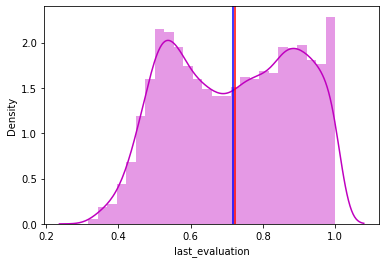

In [31]:
# Is my data normally distributed for last_evaluation column ?

sns.distplot(df_final.last_evaluation, color='m')
plt.axvline(df_final.last_evaluation.mean(), color='b')
plt.axvline(df_final.last_evaluation.median(), color='r')
plt.show()

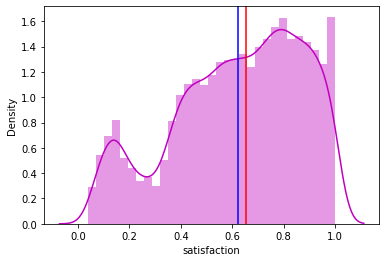

In [32]:
# Is my data normally distributed for satisfaction column ?

sns.distplot(df_final.satisfaction, color='m')
plt.axvline(df_final.satisfaction.mean(), color='b')
plt.axvline(df_final.satisfaction.median(), color='r')
plt.show()

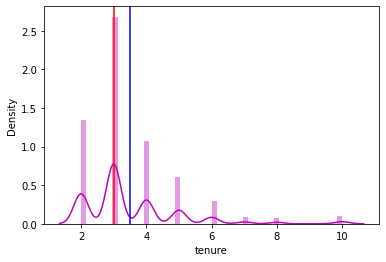

In [33]:
# Is my data normally distributed for tenure column ?

sns.distplot(df_final.tenure, color='m')
plt.axvline(df_final.tenure.mean(), color='b')
plt.axvline(df_final.tenure.median(), color='r')
plt.show()

In [34]:
# filling the missing values in "last_evaluation" by mean.
df_final.last_evaluation.fillna(df_final.last_evaluation.mean(), inplace=True)

# filling the missing values in "satisfaction" by mean.
df_final.satisfaction.fillna(df_final.satisfaction.mean(), inplace=True)

# filling the missing values in "tenure" by median.
df_final.tenure.fillna(df_final.tenure.median(), inplace=True)

df_final.shape

(13439, 14)

In [35]:
# checking for duplicate data in the final dataset

df_final[df_final.duplicated()].count()

employee_id        29
age                29
gender             29
marital_status     29
avg_monthly_hrs    29
last_evaluation    29
n_projects         29
salary             29
satisfaction       29
status             29
tenure             29
dept_id            29
dept_name          29
dept_head          29
dtype: int64

In [36]:
# drop the duplicate data

df_final.drop_duplicates(inplace = True,keep='first')
df_final.shape

(13410, 14)

In [37]:
df_final.isnull().sum().sort_values(ascending=False)

employee_id        0
age                0
gender             0
marital_status     0
avg_monthly_hrs    0
last_evaluation    0
n_projects         0
salary             0
satisfaction       0
status             0
tenure             0
dept_id            0
dept_name          0
dept_head          0
dtype: int64

## __We have removed missing, invalid and duplicate values from our dataset.__
## __OUR DATASET IS CLEAN NOW__

In [38]:
df_final.head()

,employee_id,age,gender,marital_status,avg_monthly_hrs,last_evaluation,n_projects,salary,satisfaction,status,tenure,dept_id,dept_name,dept_head
0,113558,43,Male,Married,111.0,0.753977,5,medium,0.921208,Employed,4.0,D00-PR,Procurement,Louie Viles
1,108071,36,Male,Married,151.0,0.608282,5,medium,0.210300,Employed,6.0,D00-PR,Procurement,Louie Viles
2,110888,42,Male,Married,152.0,0.673508,6,medium,0.720369,Employed,3.0,D00-PR,Procurement,Louie Viles
3,115694,26,Male,Unmarried,167.0,0.874656,3,medium,0.575996,Employed,4.0,D00-PR,Procurement,Louie Viles
4,107767,43,Male,Married,174.0,0.634783,5,medium,0.208138,Employed,5.0,D00-PR,Procurement,Louie Viles


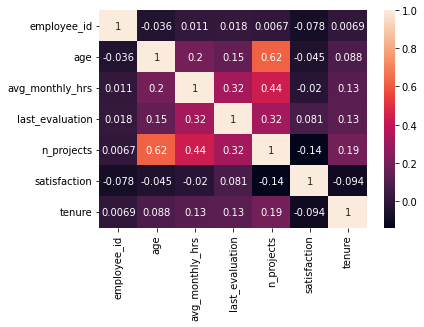

In [39]:
x = df_final.corr()
sns.heatmap(x, annot=True)
plt.show()